# Extended Wigner's friend scenario

An adapted notebook from Will pertaining to the extended Wigner's friend scenario.

This notebook is intended to run a benchmark to show a local friendliness violation from an extended Wigner's Friend scenario running on a QPU. For our friends we will use a GHZ state of increasing size. First we run on a simulator, then a noisy simulator, then on a real QPU.

Relevant References:
- [1]: ["A strong no-go theorem on the Wigner's friend paradox"](https://arxiv.org/abs/1907.05607)

- [2]: ["A scalable tripartite Wigner's friend scenario"](https://arxiv.org/abs/2109.02298)

- [3]: ["Thought experiments in a quantum computer"](https://arxiv.org/abs/2209.06236)

## Imports

In [1]:
import numpy as np
import itertools
import random
from enum import Enum

import qiskit

from qiskit_aer.noise import NoiseModel, depolarizing_error
from qiskit.providers import Backend
from qiskit.providers import fake_provider
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

## Constants

In [2]:
BACKEND = qiskit.Aer.get_backend("aer_simulator")

# Create an empty noise model
NOISE_MODEL = None

SHOTS = 10_000

In [3]:
# Import from Qiskit Aer noise module
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import pauli_error

def bitflip_model(p):
    # Example error probabilities
    p_meas = p
    p_gate1 = p

    # QuantumError objects
    error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
    error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
    error_gate2 = error_gate1.tensor(error_gate1)

    # Add errors to noise model
    noise_bit_flip = NoiseModel()
    noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
    noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["u1", "u2", "u3"])
    noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

    return noise_bit_flip

In [4]:
# Settings for extended Wigner's friend scenario.
class Setting(Enum):
    PEEK = 1
    REVERSE_1 = 2
    REVERSE_2 = 3
PEEK = Setting.PEEK.value
REVERSE_1 = Setting.REVERSE_1.value
REVERSE_2 = Setting.REVERSE_2.value
SETTINGS = [PEEK, REVERSE_1, REVERSE_2]

In [5]:
# Observers for scenario are Alice and Bob.
class Observer(Enum):
    ALICE = 0
    BOB = 1
ALICE = Observer.ALICE.value
BOB = Observer.BOB.value
OBSERVERS = [ALICE, BOB]

In [6]:
# Alice and Bob share a bipartite system of equal size.
ALICE_SIZE = 1
BOB_SIZE = 1

# Size of the systems held by the "friends" (Charlie and Debbie).
CHARLIE_SIZE = 3
DEBBIE_SIZE = 3

# Size of the bipartite quantum system.
SYS_SIZE = ALICE_SIZE + BOB_SIZE

# Two output bits for Alice and Bob.
MEAS_SIZE = 2

# Size of entire circuit
CIRCUIT_SIZE = SYS_SIZE + CHARLIE_SIZE + DEBBIE_SIZE

# Ranges for Charlie and Debbie's qubits depending on the size of their systems:
CHARLIE_QUBITS = range(SYS_SIZE, (SYS_SIZE + CHARLIE_SIZE))
DEBBIE_QUBITS = range(SYS_SIZE + CHARLIE_SIZE, SYS_SIZE + (CHARLIE_SIZE + DEBBIE_SIZE))

# Angles and beta term used for Alice and Bob measurement operators from arXiv:1907.05607.
# Note that despite the fact that degrees are used, we need to convert this to radians.
ANGLES = {PEEK: np.deg2rad(168), REVERSE_1: np.deg2rad(0), REVERSE_2: np.deg2rad(118)}
BETA = np.deg2rad(175)

## Expectation values

In [7]:
def decode_results(results: dict[str, float], charlie_size: int, debbie_size: int) -> dict[str, float]:
    """Take majority vote of measurement bit-strings."""
    decoded_results = {}
    # For each setting, there is a dictionary of measurement results.
    for setting in results:
        if setting == (PEEK, PEEK) or setting == (PEEK, REVERSE_1) or setting == (PEEK, REVERSE_2):
            setting_results = {}
            # Decode the keys for each measurement result of the setting.
            for k, v in results[setting].items():
                alice_friend, bob_friend = k[:charlie_size], k[debbie_size:]

                alice_zero_count, bob_zero_count = alice_friend.count("0"), bob_friend.count("0")
                if setting[1] == PEEK:
                    alice_decoding = "0" if alice_zero_count >= charlie_size // 2 + 1 else "1"
                    bob_decoding = "0" if bob_zero_count >= debbie_size // 2 + 1 else "1"
                else:
                    alice_decoding = "0" if alice_zero_count >= charlie_size // 2 + 1 else "1"
                    bob_decoding = "0" if bob_zero_count >= 1 else "1"


                if alice_decoding + bob_decoding in setting_results.keys():
                    setting_results[alice_decoding + bob_decoding] += v
                else:
                    setting_results[alice_decoding + bob_decoding] = v
            decoded_results[setting] = setting_results


        elif setting == (REVERSE_1, PEEK) or setting == (REVERSE_2, PEEK):
            setting_results = {}
            # Decode the keys for each measurement result of the setting.
            for k, v in results[setting].items():
                alice_friend, bob_friend = k[:1], k[1:]

                alice_zero_count, bob_zero_count = alice_friend.count("0"), bob_friend.count("0")

                alice_decoding = "0" if alice_zero_count >= 1 else "1"
                bob_decoding = "0" if bob_zero_count >= debbie_size // 2 + 1 else "1"

 
                if alice_decoding + bob_decoding in setting_results.keys():
                    setting_results[alice_decoding + bob_decoding] += v
                else:
                    setting_results[alice_decoding + bob_decoding] = v
            decoded_results[setting] = setting_results

        else:
            decoded_results[setting] = results[setting]
            
    return decoded_results

def single_expect(observer: Observer, setting: Setting, results: dict) -> dict[str, float]:
    """Compute single expectation values for either Alice or Bob."""
    if observer is ALICE:
        ret = 0
        for settings in results.keys():
            if settings[ALICE] is setting:
                probs = results[settings]
                # <A> = P(00) + P(01) - P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    + probs.get("01", 0)
                    - probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)
    else:
        ret = 0
        for settings in results.keys():
            if settings[BOB] is setting:
                probs = results[settings]
                # <B> = P(00) - P(01) + P(10) - P(11)
                ret += (
                    probs.get("00", 0)
                    - probs.get("01", 0)
                    + probs.get("10", 0)
                    - probs.get("11", 0)
                )
        return ret / len(SETTINGS)


def double_expect(settings: list[Setting], results: dict) -> float:
    """Expectation value of product of two operators."""
    probs = results[settings]
    # <AB> = P(00) - P(01) - P(10) + P(11)
    return (
        probs.get("00", 0) 
        - probs.get("01", 0) 
        - probs.get("10", 0) 
        + probs.get("11", 0)
    )    

## Consider all experimental settings

In [8]:
def generate_all_experiments(
    backend: Backend,
    noise_model: NoiseModel,
    shots: float,
    angles: list[float],
    beta: float,
    charlie_size: int,
    debbie_size: int,
    use_zne: bool = False
) -> dict[tuple[Observer, Observer], list[float]]:
    """Generate probabilitites for all combinations of experimental settings."""
    all_experiment_combos = list(itertools.product(SETTINGS, repeat=2))
    
    results = {}
    for alice, bob in all_experiment_combos:
        ewfs_circuit = ewfs(alice, bob, angles, beta, charlie_size, debbie_size)

        job = qiskit.execute(
            experiments=ewfs_circuit,
            backend=backend,
            noise_model=noise_model,
            basis_gates=noise_model.basis_gates if noise_model is not None else None,
            shots=shots,
        )
        counts = job.result().get_counts()
        
        # Convert counts to probabilities.
        probabilities = {key[::-1]: value / shots for key, value in counts.items()}

        results[(alice, bob)] = probabilities
    return results

## State preparation

In [9]:
def prepare_bipartite_system(qc: QuantumCircuit):
    """Generates the state: 1/sqrt(2) * (|01> - |10>)"""
    qc.x(ALICE)
    qc.x(BOB)
    qc.h(ALICE)
    qc.cx(ALICE, BOB)

Confirm that the state preparation circuit generates $|\psi\rangle = \frac{1}{\sqrt{2}}\left(|01\rangle - 10\rangle\right)$:

In [10]:
circuit = QuantumCircuit(2)
prepare_bipartite_system(circuit)
print(qiskit.Aer.get_backend("statevector_simulator").run(circuit).result().get_counts())

{'01': 0.5, '10': 0.5}


## CNOT ladder circuit

In [11]:
def cnot_ladder(qc: QuantumCircuit, observer: Observer, friend_qubit: int, friend_size: int, reverse: bool, internal_copy: bool):
    """CNOT ladder circuit (GHZ without Hadamard)."""
    if internal_copy:
        if reverse:
            for i in range(friend_size-1):
                qc.cx(friend_qubit + friend_size-2-i, friend_qubit+friend_size-1-i)
            qc.cx(observer, friend_qubit)
        else:
            qc.cx(observer, friend_qubit)
            for i in range(friend_size-1):
                qc.cx(friend_qubit+i, friend_qubit + i + 1)
    else:
        if reverse:
            for i in range(friend_size):
                qc.cx(observer, friend_qubit+friend_size-1-i)
        else:
            for i in range(friend_size):
                qc.cx(observer, friend_qubit + i)

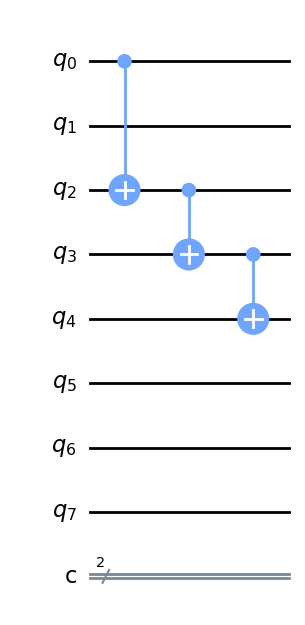

In [12]:
circuit = QuantumCircuit(CIRCUIT_SIZE, MEAS_SIZE)
cnot_ladder(circuit, ALICE, CHARLIE_QUBITS[0], CHARLIE_SIZE, reverse=False, internal_copy=True)
circuit.draw("mpl")

## Circuit for extended Wigner's friend scenario

In [13]:
def ewfs_rotation(qc: QuantumCircuit, qubit: int, angle: float):
    qc.rz(-angle, qubit)
    qc.h(qubit)
    
def apply_setting(qc: QuantumCircuit, 
                  observer: Observer, 
                  setting: Setting, 
                  angle: float, 
                  observer_creg: list[int] | int, 
                  charlie_size: int, 
                  debbie_size: int):
    """Apply either the PEEK or REVERSE_1/REVERSE_2 settings."""
    
    # Alice is the friend of Charlie and Bob is the friend of Debbie.
    charlie_qubits = range(SYS_SIZE, (SYS_SIZE + charlie_size))
    debbie_qubits = range(SYS_SIZE + charlie_size, SYS_SIZE + (charlie_size + debbie_size))
    friend_qubits = charlie_qubits if observer is ALICE else debbie_qubits
    friend_size = charlie_size if observer is ALICE else debbie_size
    
    if setting is PEEK:
        # Ask friend for the outcome.
        qc.measure(friend_qubits, observer_creg)

    elif setting in [REVERSE_1, REVERSE_2]:
        cnot_ladder(qc, observer, friend_qubits[0], friend_size, reverse=True, internal_copy=True)

        # For either REVERSE_1 or REVERSE_2, apply the appropriate angle rotations.
        # Note that in this case, the rotation should occur on the observer's qubit.
        if observer is ALICE:
            qc.h(0)
            qc.rz(ANGLES[1], 0)        

        if observer is BOB:
            qc.h(1)        
            qc.rz((BETA - ANGLES[1]), 1)
        ewfs_rotation(qc, observer, angle)            
        qc.measure(observer, observer_creg)
        
def ewfs(alice_setting: Setting, 
        bob_setting: Setting, 
        angles: list[float], 
        beta: float,
        charlie_size: int,
        debbie_size: int) -> QuantumCircuit:
    """Generate the circuit for extended Wigner's friend scenario."""    
    # Define quantum registers
    alice, bob, charlie, debbie = [
        QuantumRegister(size, name=name) 
        for size, name in zip([ALICE_SIZE, BOB_SIZE, charlie_size, debbie_size], 
                              ["Alice", "Bob", "Charlie", "Debbie"])
    ]
    if alice_setting == PEEK and bob_setting == PEEK:
        measurement = ClassicalRegister(charlie_size + debbie_size, name="Measurement")
        alice_creg = list(range(charlie_size))
        bob_creg = list(range(charlie_size, charlie_size + debbie_size))
    elif (alice_setting == PEEK and bob_setting != PEEK):
        measurement = ClassicalRegister(charlie_size + 1, name="Measurement")
        alice_creg = list(range(charlie_size))
        bob_creg = charlie_size
    elif (alice_setting != PEEK and bob_setting == PEEK):
        measurement = ClassicalRegister(debbie_size + 1, name="Measurement")
        alice_creg = 0
        bob_creg = list(range(1, charlie_size + 1))
    else:
        measurement = ClassicalRegister(MEAS_SIZE, name="Measurement")
        alice_creg = 0
        bob_creg = 1
        
    
    # Create the Quantum Circuit with the defined registers
    qc = QuantumCircuit(alice, bob, charlie, debbie, measurement)

    charlie_qubits = range(SYS_SIZE, (SYS_SIZE + charlie_size))
    debbie_qubits = range(SYS_SIZE + charlie_size, SYS_SIZE + (charlie_size + debbie_size))
    
    # Prepare the bipartite quantum system
    prepare_bipartite_system(qc)
    qc.rz(-angles[1], 0)
    qc.h(0)
    
    qc.rz(-(beta - angles[1]), 1)
    qc.h(1)

    # Apply the CNOT ladder for Alice-Charlie and Bob-Debbie
    cnot_ladder(qc, ALICE, charlie_qubits[0], charlie_size, reverse=False, internal_copy=True)
    cnot_ladder(qc, BOB, debbie_qubits[0], debbie_size, reverse=False, internal_copy=True)

    # Apply the settings for Alice/Charlie and Bob/Debbie
    apply_setting(qc, ALICE, alice_setting, angles[alice_setting], alice_creg, charlie_size, debbie_size)
    apply_setting(qc, BOB, bob_setting, (beta - angles[bob_setting]), bob_creg, charlie_size, debbie_size)

    return qc

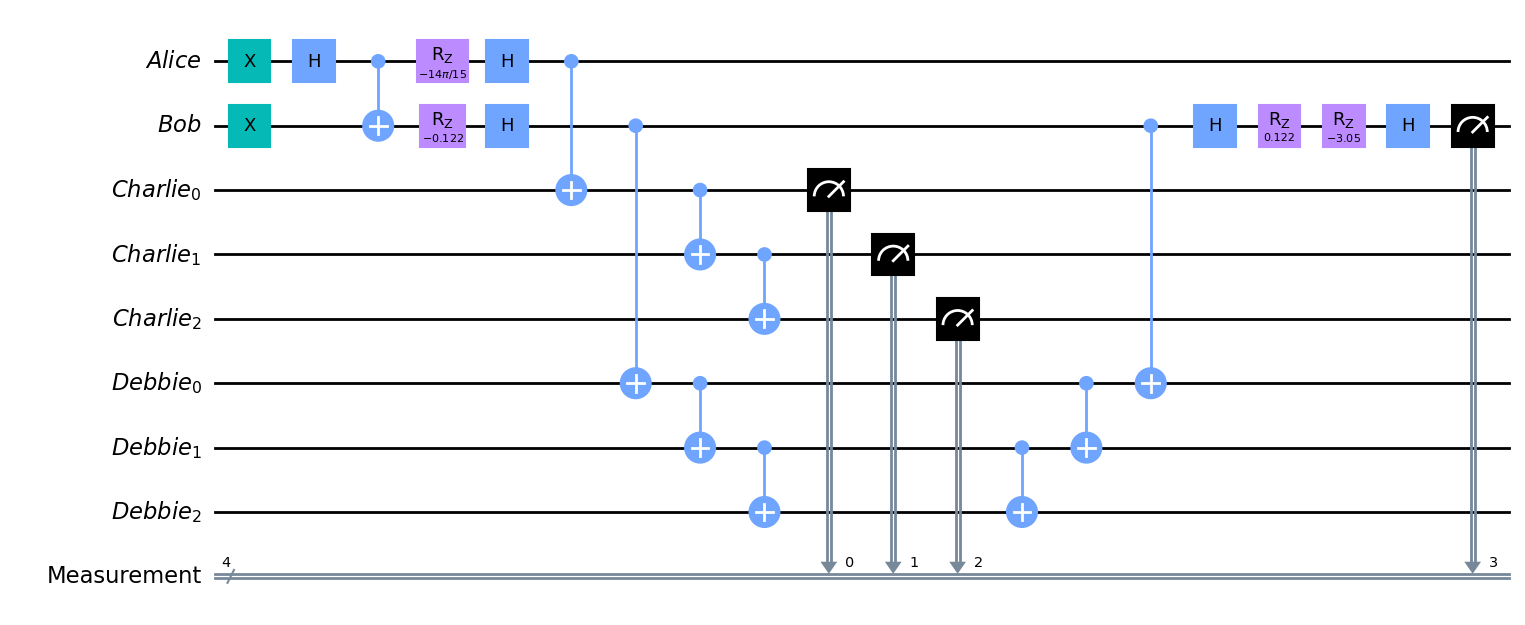

In [14]:
size = 3
setting = (1,2)
qc = ewfs(setting[0], setting[1], ANGLES, BETA, size, size)
qc.draw("mpl")

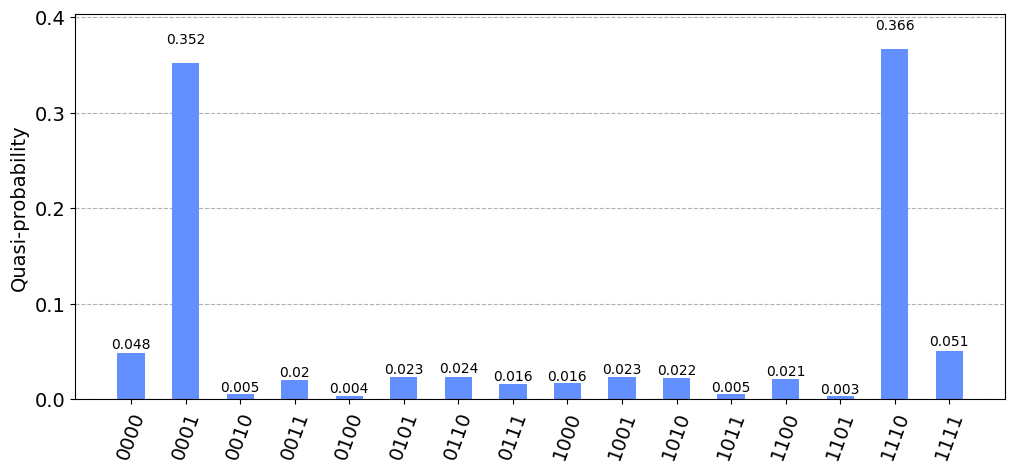

In [15]:
noise_bit_flip = bitflip_model(0.03)

job = qiskit.execute(
    experiments=qc,
    backend=BACKEND,
    noise_model=noise_bit_flip,
    basis_gates=noise_bit_flip.basis_gates if noise_bit_flip is not None else None,
    shots=1e4,
)
counts = job.result().get_counts()

# Convert counts to probabilities.
probabilities = {key[::-1]: value / 1e4 for key, value in counts.items()}

from qiskit.visualization import plot_distribution
plot_distribution(probabilities, figsize=(12, 5))

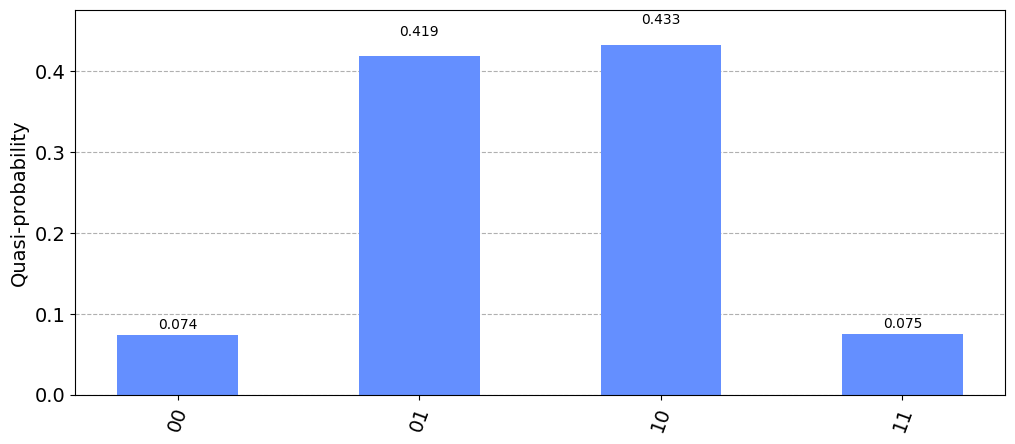

In [16]:
results = {setting: probabilities}
dec_res = decode_results(results, size, size)
probs = dec_res[setting]
plot_distribution(probs, figsize=(12, 5))


In [17]:
double_expect(setting, dec_res)

-0.7026

## Inequalities

In [18]:
def compute_inequalities(results, verbose=False):
    A1 = single_expect(ALICE, PEEK, results)
    B1 = single_expect(BOB, PEEK, results)

    A2 = single_expect(ALICE, REVERSE_1, results)
    B2 = single_expect(BOB, REVERSE_1, results)

    A3 = single_expect(ALICE, REVERSE_2, results)
    B3 = single_expect(BOB, REVERSE_2, results)

    A1B1 = double_expect((PEEK, PEEK), results)
    A1B2 = double_expect((PEEK, REVERSE_1), results)
    A1B3 = double_expect((PEEK, REVERSE_2), results)

    A2B1 = double_expect((REVERSE_1, PEEK), results)
    A2B2 = double_expect((REVERSE_1, REVERSE_1), results)
    A2B3 = double_expect((REVERSE_1, REVERSE_2), results)

    A3B1 = double_expect((REVERSE_2, PEEK), results)
    A3B2 = double_expect((REVERSE_2, REVERSE_1), results)
    A3B3 = double_expect((REVERSE_2, REVERSE_2), results)
    
    # Local-friendliness inequalities:
    # Eq. (13) from [1].
    lf = -A1 - A2 - B1 - B2 - A1B1 - 2*A1B2 - 2*A2B1 + 2*A2B2 - A2B3 - A3B2 - A3B3 - 6
    # Eq. (15) from [1].
    I3322 = -A1 + A2 + B1 - B2 + A1B1 - A1B2 - A1B3 - A2B1 + A2B2 - A2B3 - A3B1 - A3B2 - 4 

    # Brukner inequalities:
    # Eq. (17) from [1].
    brukner = A1B1 - A1B3 - A2B1 - A2B3 - 2
    # Eq. (18) from [1].
    semi_brukner = -A1B2 + A1B3 - A3B2 - A3B3 - 2

    # Bell non-LF 
    # Eq. (22) from [1].
    bell_non_lf = A2B2 - A2B3 - A3B2 - A3B3 - 2
    
    if verbose:
        print("******Inequalities******")
        print(f"{semi_brukner=} -- is violated: {semi_brukner > 0}")
        print(f"{brukner=} -- is violated: {brukner > 0}")
        print(f"{lf=} -- is violated: {lf > 0}")
        print(f"{I3322=} -- is_violated: {I3322 > 0}")
        print(f"{bell_non_lf=} -- is_violated: {bell_non_lf > 0}")
        print("**************************")
        
    return {
        "lf": lf,
        "I3322": I3322,
        "brukner": brukner,
        "semi_brukner": semi_brukner,
        "bell_non_lf": bell_non_lf,
    }

In [19]:
sizes = [1, 3, 5]
ps = np.linspace(0.0, 0.03, 10)

all_results = []

for size in sizes:
    semi_brukner_decoded_results=[]
    for p in ps:
        noise_bit_flip = bitflip_model(p)
        results = generate_all_experiments(backend=BACKEND, noise_model=noise_bit_flip, shots=SHOTS, angles=ANGLES, beta=BETA, charlie_size=size, debbie_size=size)
        semi_brukner_decoded = compute_inequalities(decode_results(results, charlie_size=size, debbie_size=size), verbose=False)['semi_brukner']
        semi_brukner_decoded_results.append(semi_brukner_decoded)
    all_results.append(semi_brukner_decoded_results)

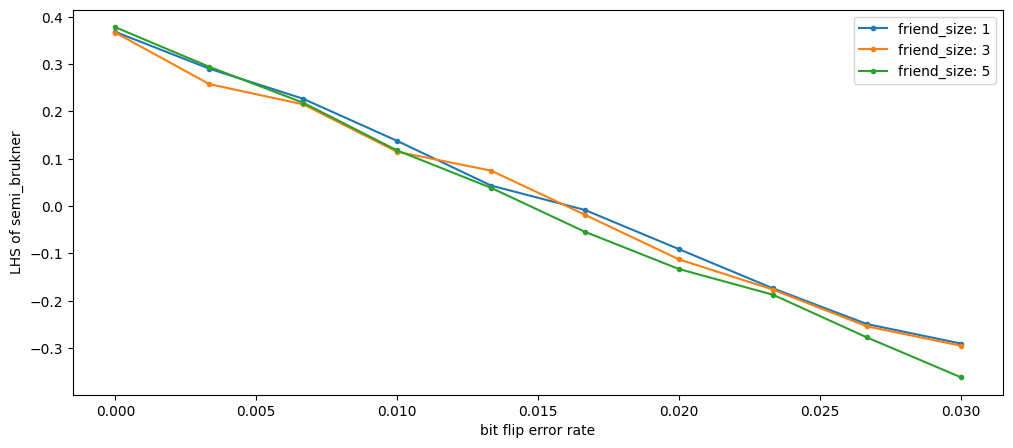

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 5))
for i, res in enumerate(all_results):
    plt.plot(ps, res, '.-', label=f'friend_size: {sizes[i]}')

plt.legend()
plt.xlabel('bit flip error rate')
plt.ylabel('LHS of semi_brukner')
plt.show()

In [21]:
def run_experiment(
    backend: Backend,
    noise_model: NoiseModel,
    friend_sizes: list[int],
    shots: float,
    use_zne: bool = False,
    num_trials: int = 1
):
    violations = []
    for friend_size in friend_sizes:
        results = generate_all_experiments(
            backend=backend,
            noise_model=noise_model,
            shots=shots,
            angles=ANGLES,
            beta=BETA,
            charlie_size=friend_size,
            debbie_size=friend_size,
            use_zne=use_zne,
        )
        violations.append(compute_inequalities(decode_results(results, charlie_size=friend_size, debbie_size=friend_size), verbose=False))

    values = {}
    for d in violations:
        for key, value in d.items():
            values.setdefault(key, []).append(value)
    return values

In [22]:
friend_sizes = range(1, 7)
num_trials = 10
shots = 10_000

# Data: Simulator
print("Running data for simulator...")
simulator_values = run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=None,
    friend_sizes=friend_sizes,
    shots=shots,
)
        
# Data: 1% depolarizing simulator
print("Running data for 1% depolarizing noise simulator...")
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.01, 1), ["u1", "u2", "u3"])
depolarizing_values_1 = run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
)
    
# Data: 5% depolarizing simulator
print("Running data for 5% depolarizing noise simulator...")
noise_model = NoiseModel()
noise_model.add_all_qubit_quantum_error(depolarizing_error(0.05, 1), ["u1", "u2", "u3"])
depolarizing_values_10 = run_experiment(
    backend=qiskit.Aer.get_backend("aer_simulator"),
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
)

# Data: FakeKolkata
print("Running data for FakeKolkata...")
backend = fake_provider.FakeKolkata()
noise_model = NoiseModel.from_backend(backend)
fake_kolkata_values = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    shots=shots,
)

# # Data: FakeKolkata (with ZNE)
# print("Running data for FakeKolkata (with ZNE)...")
# backend = fake_provider.FakeKolkata()
# noise_model = NoiseModel.from_backend(backend)
# fake_kolkata_values_with_zne = run_experiment(
#     backend=backend,
#     noise_model=noise_model,
#     friend_sizes=friend_sizes,
#     shots=shots,
#     use_zne=True,
# )

Running data for simulator...
Running data for 1% depolarizing noise simulator...
Running data for 5% depolarizing noise simulator...
Running data for FakeKolkata...


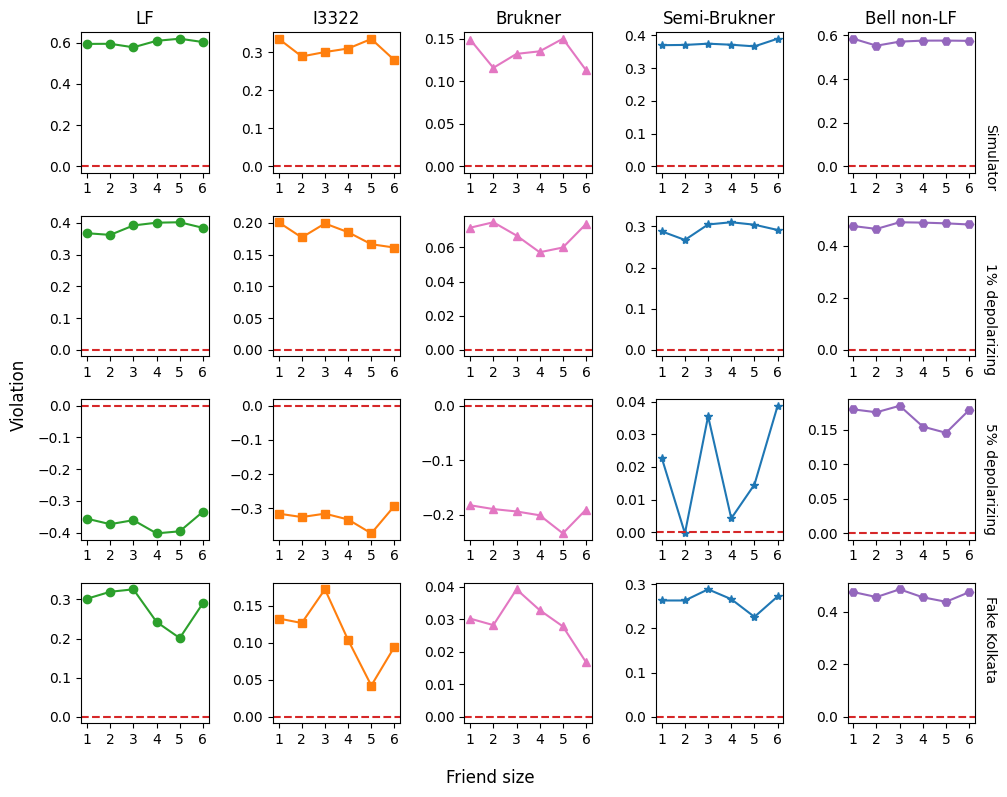

In [23]:
fig, axs = plt.subplots(nrows=4, ncols=5, figsize=(10, 8))

# Plot: simulator
axs[0, 0].plot(friend_sizes, simulator_values["lf"], marker="o", color="tab:green")
axs[0, 0].set_title("LF")
axs[0, 0].set_xticks(friend_sizes)

axs[0, 1].plot(friend_sizes, simulator_values["I3322"], marker="s", color="tab:orange")
axs[0, 1].set_title("I3322")
axs[0, 1].set_xticks(friend_sizes)

axs[0, 2].plot(friend_sizes, simulator_values["brukner"], marker="^", color="tab:pink")
axs[0, 2].set_title("Brukner")
axs[0, 2].set_xticks(friend_sizes)

axs[0, 3].plot(friend_sizes, simulator_values["semi_brukner"], marker="*", color="tab:blue")
axs[0, 3].set_title("Semi-Brukner")
axs[0, 3].set_xticks(friend_sizes)

axs[0, 4].plot(friend_sizes, simulator_values["bell_non_lf"], marker="H", color="tab:purple")
axs[0, 4].set_title("Bell non-LF")
axs[0, 4].set_xticks(friend_sizes)

# Plot: 1% depolarizing noise
axs[1, 0].plot(friend_sizes, depolarizing_values_1["lf"], marker="o", color="tab:green")
axs[1, 0].set_xticks(friend_sizes)

axs[1, 1].plot(friend_sizes, depolarizing_values_1["I3322"], marker="s", color="tab:orange")
axs[1, 1].set_xticks(friend_sizes)

axs[1, 2].plot(friend_sizes, depolarizing_values_1["brukner"], marker="^", color="tab:pink")
axs[1, 2].set_xticks(friend_sizes)

axs[1, 3].plot(friend_sizes, depolarizing_values_1["semi_brukner"], marker="*", color="tab:blue")
axs[1, 3].set_xticks(friend_sizes)

axs[1, 4].plot(friend_sizes, depolarizing_values_1["bell_non_lf"], marker="H", color="tab:purple")
axs[1, 4].set_xticks(friend_sizes)

# Plot: 5% depolarizing noise
axs[2, 0].plot(friend_sizes, depolarizing_values_10["lf"], marker="o", color="tab:green")
axs[2, 0].set_xticks(friend_sizes)

axs[2, 1].plot(friend_sizes, depolarizing_values_10["I3322"], marker="s", color="tab:orange")
axs[2, 1].set_xticks(friend_sizes)

axs[2, 2].plot(friend_sizes, depolarizing_values_10["brukner"], marker="^", color="tab:pink")
axs[2, 2].set_xticks(friend_sizes)

axs[2, 3].plot(friend_sizes, depolarizing_values_10["semi_brukner"], marker="*", color="tab:blue")
axs[2, 3].set_xticks(friend_sizes)

axs[2, 4].plot(friend_sizes, depolarizing_values_10["bell_non_lf"], marker="H", color="tab:purple")
axs[2, 4].set_xticks(friend_sizes)


# Plot: FakeKolkata
axs[3, 0].plot(friend_sizes, fake_kolkata_values["lf"], marker="o", color="tab:green")
axs[3, 0].set_xticks(friend_sizes)

axs[3, 1].plot(friend_sizes, fake_kolkata_values["I3322"], marker="s", color="tab:orange")
axs[3, 1].set_xticks(friend_sizes)

axs[3, 2].plot(friend_sizes, fake_kolkata_values["brukner"], marker="^", color="tab:pink")
axs[3, 2].set_xticks(friend_sizes)

axs[3, 3].plot(friend_sizes, fake_kolkata_values["semi_brukner"], marker="*", color="tab:blue")
axs[3, 3].set_xticks(friend_sizes)

axs[3, 4].plot(friend_sizes, fake_kolkata_values["bell_non_lf"], marker="H", color="tab:purple")
axs[3, 4].set_xticks(friend_sizes)

# # Plot: FakeKolkata (with ZNE)
# axs[4, 0].plot(friend_sizes, fake_kolkata_values_with_zne["lf"], marker="o", color="tab:green")
# axs[4, 0].set_xticks(friend_sizes)

# axs[4, 1].plot(friend_sizes, fake_kolkata_values_with_zne["I3322"], marker="s", color="tab:orange")
# axs[4, 1].set_xticks(friend_sizes)

# axs[4, 2].plot(friend_sizes, fake_kolkata_values_with_zne["brukner"], marker="^", color="tab:pink")
# axs[4, 2].set_xticks(friend_sizes)

# axs[4, 3].plot(friend_sizes, fake_kolkata_values_with_zne["semi_brukner"], marker="*", color="tab:blue")
# axs[4, 3].set_xticks(friend_sizes)

# axs[4, 4].plot(friend_sizes, fake_kolkata_values_with_zne["bell_non_lf"], marker="H", color="tab:purple")
# axs[4, 4].set_xticks(friend_sizes)


# Adding a red dotted line at y = 0 for each subplot for violation threshold.
for ax in axs.flat:
    ax.axhline(y=0, color="tab:red", linestyle="--")

# Set row labels on the right side
# fig.text(1, 0.89, "Simulator", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.7, "1% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.52, "10% depolarizing", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.35, "FakeKolkata", ha="center", va="center", rotation=-90, fontsize=8)
# fig.text(1, 0.15, "FakeKolkata (w/ZNE)", ha="center", va="center", rotation=-90, fontsize=8)

row_titles = [
    "Simulator", "1% depolarizing", "5% depolarizing", "Fake Kolkata"
]
num_rows = len(axs)
for i in range(num_rows):
    row_label_y_position = axs[i, 0].get_position().y0 + axs[i, 0].get_position().height / 2
    fig.text(1, row_label_y_position, row_titles[i], ha="center", va="center", rotation=-90, fontsize=10)

fig.supxlabel("Friend size")
fig.supylabel("Violation")

plt.tight_layout()

plt.savefig("simulator_violations.pdf", bbox_inches="tight")
plt.show()

In [24]:
def plot_results(
    ax,
    results: dict, 
    friend_sizes: list[int], 
    plot_title: str,
    plot_error_bars: bool = False, 
):
    # Compute averages and standard deviations
    avg_results = {}
    std_results = {}
    for fs in results:
        avg_results[fs] = {}
        std_results[fs] = {}
        for key in results[fs]:
            avg_results[fs][key] = np.mean(results[fs][key])
            if plot_error_bars:
                std_results[fs][key] = np.std(results[fs][key])

    # Plotting    
    markers = ["o", "s", "^", "*", "H"]
    colors = ["tab:green", "tab:orange", "tab:pink", "tab:blue", "tab:purple"]
    titles = ["LF", "I3322", "Brukner", "Semi-Brukner", "Bell non-LF"]

    for i, key in enumerate(["lf", "I3322", "brukner", "semi_brukner", "bell_non_lf"]):
        means = [np.mean(results[fs][key]) for fs in friend_sizes]
        errors = [np.std(results[fs][key]) for fs in friend_sizes] if plot_error_bars else None
        ax.errorbar(friend_sizes, means, yerr=errors, label=titles[i], fmt=markers[i], color=colors[i], capsize=5)

    ax.axhline(0, color="red", linestyle="dashed")
    ax.set_xticks(friend_sizes)
    ax.set_title(plot_title)
    ax.grid(True)


def run_experiment(
    backend: Backend,
    noise_model: NoiseModel,
    friend_sizes: list[int],
    shots: float,
    use_zne: bool = False,
    verbose: bool = True,
    num_trials: int = 1
):
    all_results = {
        fs: {inequality: [] for inequality in ["lf", "I3322", "brukner", "semi_brukner", "bell_non_lf"]}
        for fs in friend_sizes
    }

    for friend_size in friend_sizes:
        for _ in range(num_trials):
            results = generate_all_experiments(
                backend=backend,
                noise_model=noise_model,
                shots=shots,
                angles=ANGLES,
                beta=BETA,
                charlie_size=friend_size,
                debbie_size=friend_size,
                use_zne=use_zne,
            )
            violations = compute_inequalities(decode_results(results, charlie_size=friend_size, debbie_size=friend_size), verbose=False)

            for key in violations:
                all_results[friend_size][key].append(violations[key])

    return all_results

def depolarizing_noise_model(error: float = 0.01) -> NoiseModel:
    """Defines an depolarizing noise model with one-qubit.
    
    Args:
        error: One-qubit gate error rate (default 1%).
    Returns:
        Depolarizing noise model.
    """
    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(depolarizing_error(error, 1), ["u1", "u2", "u3"])       
    return noise_model    

In [25]:
# Parameters for all plots
friend_sizes = range(1, 7)
num_trials = 10
shots = 10_000
backend = qiskit.Aer.get_backend("aer_simulator")

# Ideal simulator data
noise_model = None
simulator_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

# Depolarizing noise (1%)
noise_model = depolarizing_noise_model(error=0.01)
depolarizing_1perc_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

# Depolarizing noise (2%)
noise_model = depolarizing_noise_model(error=0.02)
depolarizing_2perc_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

# Depolarizing noise (3%)
noise_model = depolarizing_noise_model(error=0.03)
depolarizing_3perc_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

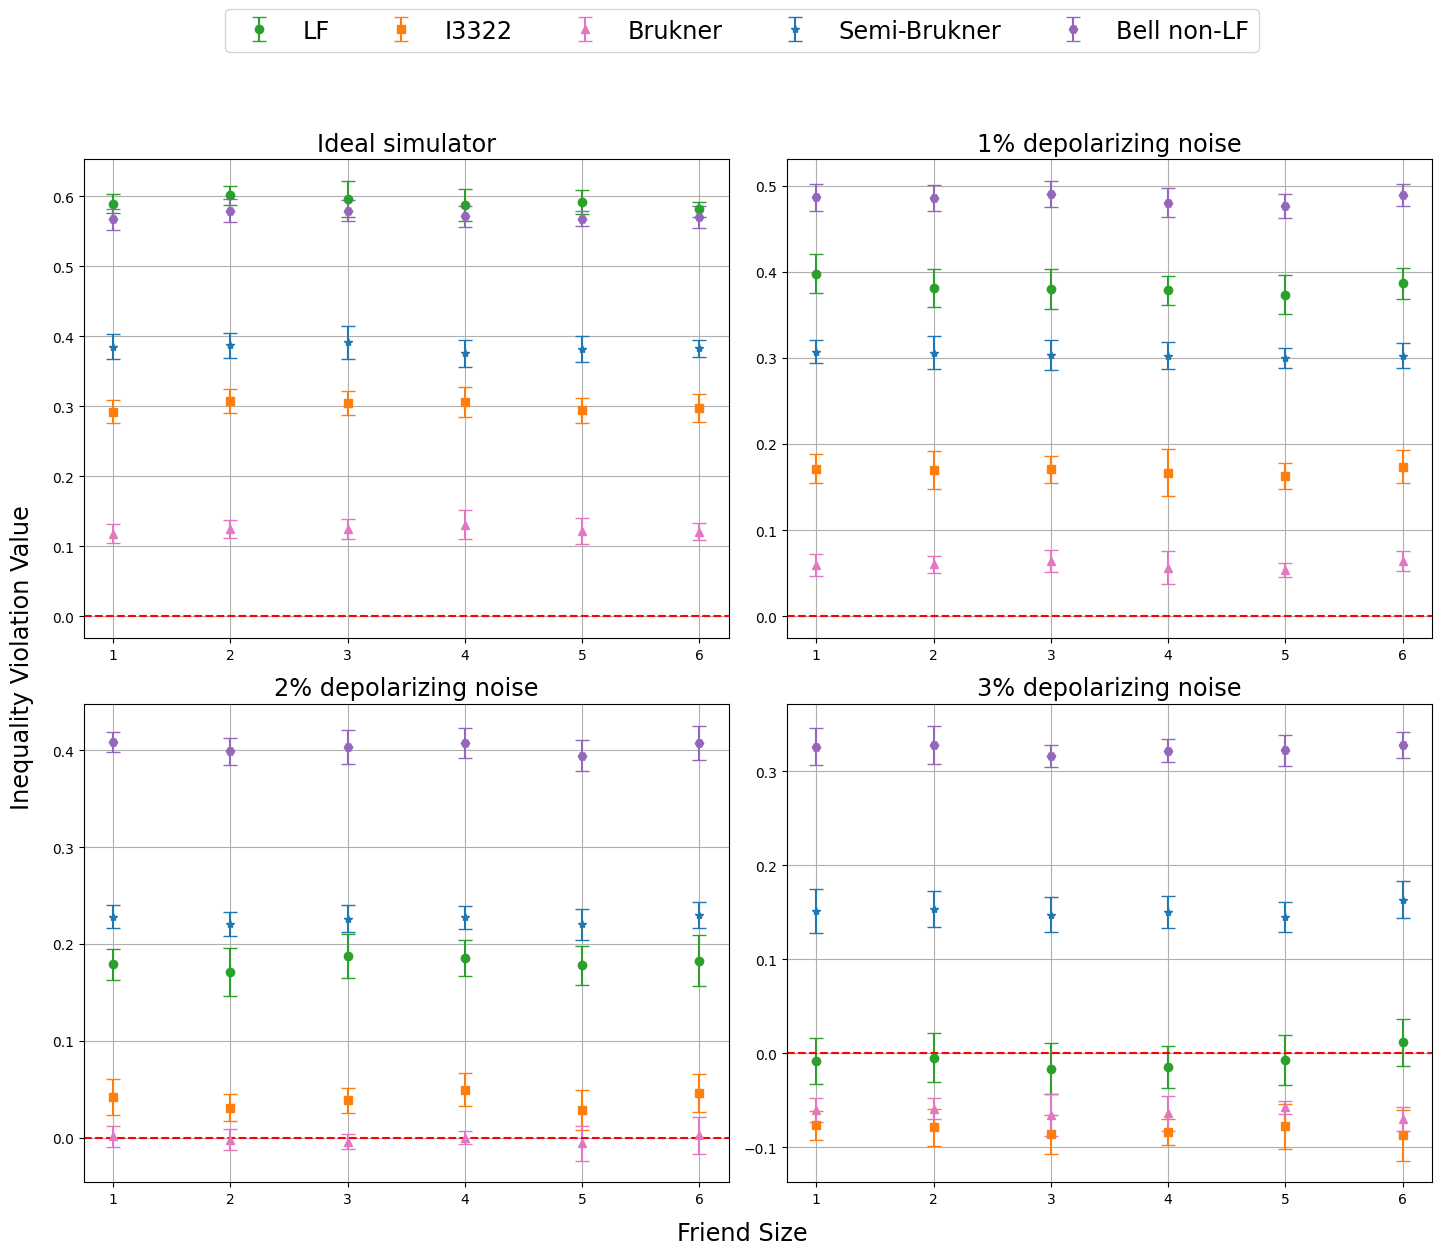

In [26]:
fig, axs = plt.subplots(2,2, figsize=(15, 12))  # Create a figure with two subplots

plot_results(axs[0,0], simulator_results, friend_sizes, plot_error_bars=True, plot_title="Ideal simulator")
plot_results(axs[0,1], depolarizing_1perc_results, friend_sizes, plot_error_bars=True, plot_title="1% depolarizing noise")
plot_results(axs[1,0], depolarizing_2perc_results, friend_sizes, plot_error_bars=True, plot_title="2% depolarizing noise")
plot_results(axs[1,1], depolarizing_3perc_results, friend_sizes, plot_error_bars=True, plot_title="3% depolarizing noise")

# Use the legend from the first subplot
handles, labels = axs[0,0].get_legend_handles_labels()

# Create a single shared legend
fig.legend(handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize="xx-large")

# Set common x-axis and y-axis labels
fig.text(0.5, 0.02, "Friend Size", ha="center", va="center", fontsize="xx-large")
fig.text(0.02, 0.5, "Inequality Violation Value", ha="center", va="center", rotation="vertical", fontsize="xx-large")

for ax in np.ravel(axs):
    ax.set_title(ax.get_title(), fontsize="xx-large")

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig("ghz_noise_levels_vs_friend_sizes.pdf", bbox_inches="tight")
plt.show()

In [29]:
friend_sizes = range(1, 6)
num_trials = 10
shots = 10_000

# Fake Kolkata
backend = fake_provider.FakeKolkataV2()
noise_model = NoiseModel.from_backend(backend)
fake_kolkata_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

# Fake Sherbrooke
backend = fake_provider.FakeSherbrooke()
noise_model = NoiseModel.from_backend(backend)
fake_sherbrooke_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

# Fake Hanoi
backend = fake_provider.FakeHanoiV2()
noise_model = NoiseModel.from_backend(backend)
fake_hanoi_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

# Fake Cairo
backend = fake_provider.FakeCairoV2()
noise_model = NoiseModel.from_backend(backend)
fake_cairo_results = run_experiment(
    backend=backend,
    noise_model=noise_model,
    friend_sizes=friend_sizes,
    num_trials=num_trials,
    shots=shots,    
    verbose=False,
)

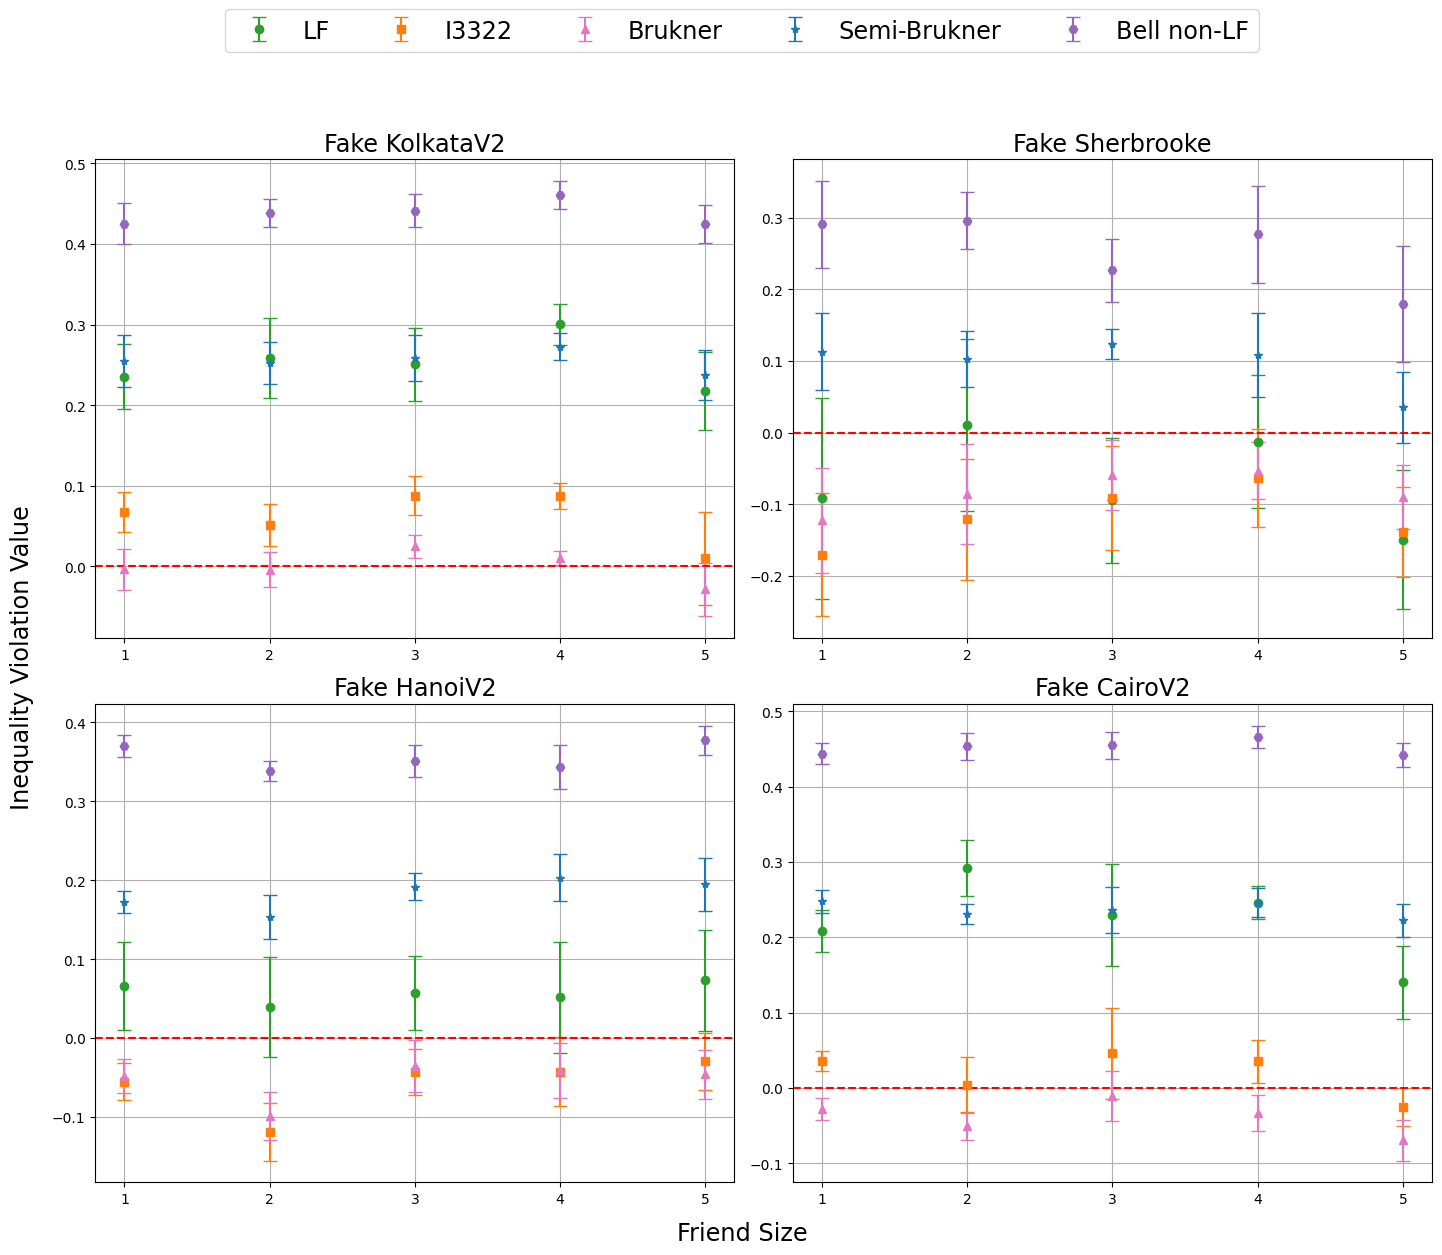

In [32]:
fig, axs = plt.subplots(2,2, figsize=(15, 12))  # Create a figure with two subplots

plot_results(axs[0,0], fake_kolkata_results, friend_sizes, plot_error_bars=True, plot_title="Fake KolkataV2")
plot_results(axs[0,1], fake_sherbrooke_results, friend_sizes, plot_error_bars=True, plot_title="Fake Sherbrooke")
plot_results(axs[1,0], fake_hanoi_results, friend_sizes, plot_error_bars=True, plot_title="Fake HanoiV2")
plot_results(axs[1,1], fake_cairo_results, friend_sizes, plot_error_bars=True, plot_title="Fake CairoV2")

# Use the legend from the first subplot
handles, labels = axs[0,0].get_legend_handles_labels()

# Create a single shared legend
fig.legend(handles, labels, loc="upper center", ncol=len(labels), bbox_to_anchor=(0.5, 1.05), fontsize="xx-large")

# Set common x-axis and y-axis labels
fig.text(0.5, 0.02, "Friend Size", ha="center", va="center", fontsize="xx-large")
fig.text(0.02, 0.5, "Inequality Violation Value", ha="center", va="center", rotation="vertical", fontsize="xx-large")

for ax in np.ravel(axs):
    ax.set_title(ax.get_title(), fontsize="xx-large")

plt.tight_layout(rect=[0.03, 0.03, 0.97, 0.95])
plt.savefig("ghz_noise_levels_vs_friend_sizes_fake_devices.pdf", bbox_inches="tight")
plt.show()